### shap text
shap word hier gebruikt om uit te legen wat dit model belangrijk vind

In [19]:
from time import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import pickle

import warnings
warnings.filterwarnings('ignore')

#### bereid de data voor

In [2]:
FOLDER_PATH_2022 = '../../data/cleaned_data/cleaned_text_data_2022.csv'


In [3]:
df_2022 = pd.read_csv(FOLDER_PATH_2022)

df_2022.shape

(7903, 4)

In [32]:
# Maak X en y variabelen aan
X = df_2022['full_text']
y = df_2022['real_fake_grade']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

vectorizer = TfidfVectorizer()
#
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
#vectorizer.get_feature_names()





#### maak de SVM

In [6]:
svc_tweet_2022 = SVC(probability=True, C=10, gamma=1, kernel='rbf')



svc_tweet_2022.fit(X_train, y_train)


SVC(C=10, gamma=1, probability=True)

#### shap maken

In [7]:
from tqdm import tqdm
import shap
shap.initjs()

In [10]:
X_train_sample = shap.sample(X_train, 200)

In [11]:
explainer = shap.KernelExplainer(svc_tweet_2022.predict,X_train_sample)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [13]:
shap_values = explainer.shap_values(shap.sample(X_test, 25))


100%|██████████| 25/25 [7:58:35<00:00, 1148.63s/it]  


save de shap valeus als een np array in een csv

In [14]:
from numpy import savetxt
savetxt('shapText.csv', shap_values, delimiter=',')

shap inladen

In [15]:
from numpy import loadtxt
# load array
shap_values_loaded = loadtxt('shapText.csv', delimiter=',')

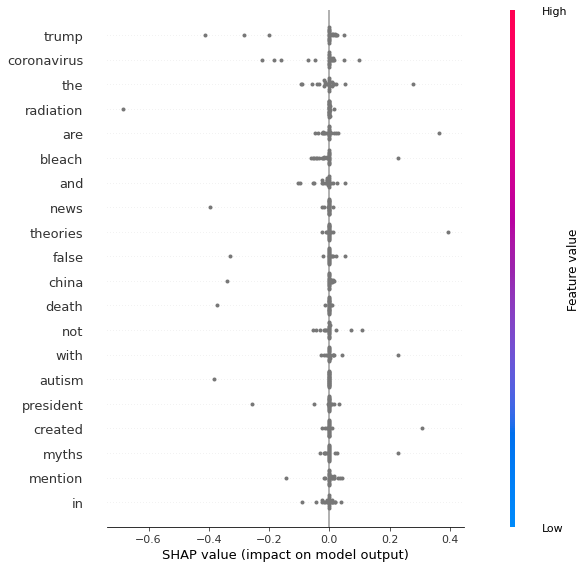

In [33]:
shap.summary_plot(shap_values_loaded,X_test[:25], feature_names=vectorizer.get_feature_names(), show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(10)

In [35]:
shap.force_plot(explainer.expected_value, shap_values_loaded[1],
    feature_names=vectorizer.get_feature_names())

### bert
Helaas is deze niet gelukt er zijn errors waar we niet zijn uitgenomen

In [39]:
import numpy as np 
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import sys
sys.path.append("../") # make it possible to import functions from different files that are in folders a level up
from text.tools.bert_model import get_model, MAX_LEN
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

Some layers from the model checkpoint at digitalepidemiologylab/covid-twitter-bert-v2 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at digitalepidemiologylab/covid-twitter-bert-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [43]:
model = get_model()

model.load_weights("bert-tweet2022-weights.h5")


In [144]:
folder_path = '../../data/cleaned_data/cleaned_text_data_with_stopwords_2022.csv'

data = pd.read_csv(folder_path)

data.head()

,full_text,real_fake_grade,text_metadata,combined
0,daily update published state reported 734k tes...,1.0,covid tracking project try provide comprehensi...,covid tracking project try provide comprehensi...
1,president trump asked would catch coronavirus ...,-1.0,spoof spoof news political satire parody gossi...,spoof spoof news political satire parody gossi...
2,state reported death still seeing solid nation...,1.0,covid tracking project try provide comprehensi...,covid tracking project try provide comprehensi...
3,low vitamind independent predictor worse progn...,1.0,medscape medscape provides breaking medical ne...,medscape medscape provides breaking medical ne...
4,common question cumulative outcome number smal...,1.0,covid tracking project try provide comprehensi...,covid tracking project try provide comprehensi...


In [45]:
data.shape

(7903, 4)

In [46]:
data.dropna(inplace=True)
data.shape

(7901, 4)

In [47]:
data['real_fake_grade']  = data['real_fake_grade'].map({0:0, 1:1, -1:2})

In [48]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('digitalepidemiologylab/covid-twitter-bert-v2')

In [181]:
y = data['real_fake_grade']
maxlen = 80
X = data['full_text']


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1, random_state=42)

y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)

# Tokenize the input (takes some time) 
x_train = tokenizer(
    text=X_train.tolist(),
    add_special_tokens=True,
    max_length=maxlen,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_val = tokenizer(
    text=X_val.tolist(),
    add_special_tokens=True,
    max_length=maxlen,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = tokenizer( # for prediction
    text=X_test.tolist(),
    add_special_tokens=True,
    max_length=maxlen,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
    


In [146]:
tweet_2022_model = get_model(maxlen=80)

In [147]:
tweet_2022_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 80)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 80)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    multiple             335141888   ['input_ids[0][0]',              
                                                                  'attention_mask[0][0]']         
                                                                                                  
 dense_9 (Dense)                (None, 128)          131200      ['tf_bert_model[3][1]']    

In [148]:
masker = shap.maskers.Text(tokenizer=r"\W+")
selected_categories = [0,1,2]


    

In [183]:
X_train_sample = shap.sample(X_train, 200)

In [185]:
X_train_sample = np.array(X_train_sample)

In [174]:
explainer = shap.Explainer(model.predict)


In [152]:
X_train_sample.shape

(200,)

In [189]:
shap_values = explainer([X_train['input_ids'], X_train['attention_mask']])

KeyError: 'input_ids'

In [190]:
shap_values = explainer.shap_values(X_train_sample)

IndexError: tuple index out of range